# FAIR

This notebook gives some simple examples of how to run and use the Finite Amplitude Impulse Response (FAIR) model. 

The  Finite  Amplitude  Impulse  Response  (FAIR)  model  is  a  simple emissions-based climate model. It allows the user to input emissions of greenhouse gases and short lived climate forcers in order to estimate global mean atmospheric GHG concentrations, radiative forcing and temperature anomalies.

The original FAIR model was developed to simulate the earth system response to CO$_2$ emissions, with all non-CO$_2$ forcing implemented as an "external" source. It was developed by Richard Millar, Zebedee Nicholls, Pierre Friedlingstein and Myles Allen. The motivation for developing it and its formulation is documented in  a  paper  published  in  Atmospheric  Chemistry  and  Physics  in  2017 (doi:10.5194/acp-2016-405).

The emissions-based model extends FAIR by replacing all sources of non-CO$_2$ forcing with relationships that are based on the source emissions, with the exception of natural forcings (viz. variations in solar irradiance and volcanic eruptions). It is useful for assessing future policy commitments to anthropogenic emissions (something which we can control) than to radiative forcing (something which is less certain and which we can only partially control).

The emissions based model was developed by Chris Smith with input from Piers Forster, Leighton Regayre and Giovanni Passerello, in parallel with Nicolas Leach, Richard Millar and Myles Allen.

In [1]:
import fair
fair.__version__

'1.1.2+0.g9b36011.dirty'

In [2]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 16, 9
print(plt.style)

<module 'matplotlib.style' from '/nfs/see-fs-02_users/mencsm/.local/lib/python2.7/site-packages/matplotlib/style/__init__.pyc'>


## Basic run

Here we show how FAIR can be run with step change CO$_2$ emissions and sinusoidal non-CO$_2$ forcing timeseries.

Text(0,0.5,u'Temperature anomaly (K)')

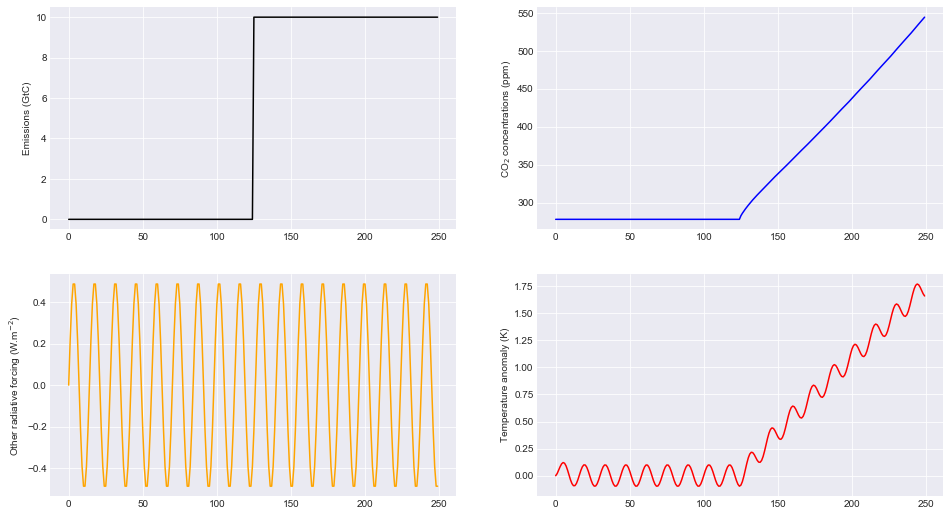

In [3]:
emissions = np.zeros(250)
emissions[125:] = 10.0
other_rf = np.zeros(emissions.size)
for x in range(0,emissions.size):
    other_rf[x] = 0.5*np.sin(2*np.pi*(x)/14.0)
    
C,F,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=other_rf)

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0,emissions.size),emissions,color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0,emissions.size),C,color='blue')
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0,emissions.size),other_rf,color='orange')
ax3.set_ylabel('Other radiative forcing (W.m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0,emissions.size),T,color='red')
ax4.set_ylabel('Temperature anomaly (K)')

## RCPs

We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios. To use the emissions-based version specify ```useMultigas=True``` in the call to ```fair_scm()```.

Text(0,0.5,u'Temperature anomaly (K)')

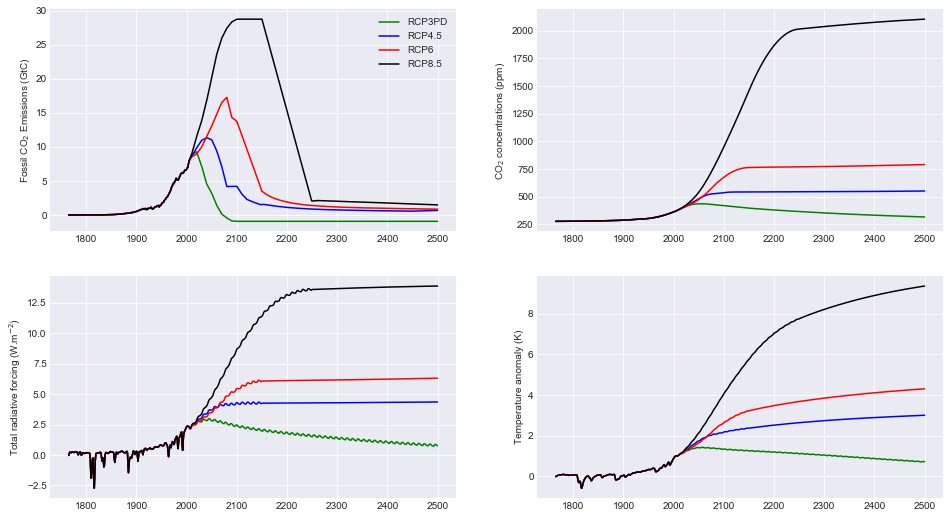

In [4]:
from fair.RCPs import rcp3pd, rcp45, rcp6, rcp85
from fair.ancil import natural

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

C,F,T = fair.forward.fair_scm(emissions  = rcp3pd.Emissions.emissions,
                              F_solar    = rcp3pd.Forcing.solar,
                              F_volcanic = rcp3pd.Forcing.volcanic,
                              natural    = natural.Emissions.emissions,
                              useMultigas= True)
ax1.plot(rcp3pd.Emissions.year, rcp3pd.Emissions.co2_fossil, color='green', label='RCP3PD')
ax2.plot(rcp3pd.Emissions.year, C[:,0], color='green')
ax3.plot(rcp3pd.Emissions.year, np.sum(F, axis=1), color='green')
ax4.plot(rcp3pd.Emissions.year, T, color='green')

C,F,T = fair.forward.fair_scm(emissions  = rcp45.Emissions.emissions,
                              F_solar    = rcp45.Forcing.solar,
                              F_volcanic = rcp45.Forcing.volcanic,
                              natural    = natural.Emissions.emissions,
                              useMultigas= True)
ax1.plot(rcp45.Emissions.year, rcp45.Emissions.co2_fossil, color='blue', label='RCP4.5')
ax2.plot(rcp45.Emissions.year, C[:,0], color='blue')
ax3.plot(rcp45.Emissions.year, np.sum(F, axis=1), color='blue')
ax4.plot(rcp45.Emissions.year, T, color='blue')

C,F,T = fair.forward.fair_scm(emissions  = rcp6.Emissions.emissions,
                              F_solar    = rcp6.Forcing.solar,
                              F_volcanic = rcp6.Forcing.volcanic,
                              natural    = natural.Emissions.emissions,
                              useMultigas= True)
ax1.plot(rcp6.Emissions.year, rcp6.Emissions.co2_fossil, color='red', label='RCP6')
ax2.plot(rcp6.Emissions.year, C[:,0], color='red')
ax3.plot(rcp6.Emissions.year, np.sum(F, axis=1), color='red')
ax4.plot(rcp6.Emissions.year, T, color='red')

C,F,T = fair.forward.fair_scm(emissions  = rcp85.Emissions.emissions,
                              F_solar    = rcp85.Forcing.solar,
                              F_volcanic = rcp85.Forcing.volcanic,
                              natural    = natural.Emissions.emissions,
                              useMultigas= True)
ax1.plot(rcp85.Emissions.year, rcp85.Emissions.co2_fossil, color='black', label='RCP8.5')
ax2.plot(rcp85.Emissions.year, C[:,0], color='black')
ax3.plot(rcp85.Emissions.year, np.sum(F, axis=1), color='black')
ax4.plot(rcp85.Emissions.year, T, color='black')

ax1.set_ylabel('Fossil CO$_2$ Emissions (GtC)')
ax1.legend()
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3.set_ylabel('Total radiative forcing (W.m$^{-2}$)')
ax4.set_ylabel('Temperature anomaly (K)')